<a href="https://colab.research.google.com/github/nessb26/certificate_tutorial_week6_aglo/blob/main/Test_project_Asset_Management_week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Class-Based Implementation of Mean-Variance Portfolios

Implement a class that does the following:

    uses the data set https://hilpisch.com/indices_eikon_eod_data.csv
    allows to define the investable universe (= set of instruments to be used)
    assumes that 100% of a capital base is to be invested (normalized portfolios)
    allows to define whether short sales are allowed or not
    allows to define a maximum (in negative %) for any short position (say, -0.1 for "10% short")
    calculates for an arbitraty portfolio composition (in line with the before assumptions/constraints) the expected return and the volatility of the portfolio
    simulates random portfolio compositions including risk-return statistics and allows for the visualization of these statistics
    uses optimization techniques with freely defined bounds (say, "every asset shall have a minimum allocation of 5%") to ...
        ... derive the minimum risk portfolio
        ... derive the maximum Sharpe portfolio
        ... derive and visualize the efficient frontier



In [1]:
import numpy as np
import pandas as pd
from pylab import plt, mpl
from scipy.optimize import minimize
plt.style.use('seaborn')
np.set_printoptions(precision=5, suppress=True,
                   formatter={'float': lambda x: f'{x:6.3f}'})

In [2]:
class MV_Portfolio:
  #we dont need to have a variable determining if short are allowed, this information is contained in lowerBound Vector
  def __init__(self,symbols,lower_bound):
        self.symbols=symbols
        self.lower_bound=lower_bound                        
        self.get_data()
         
  def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        url='http://hilpisch.com/pyalgo_eikon_eod_data.csv'
        raw = pd.read_csv(url, index_col=0, parse_dates=True).dropna()
        self.data = raw.dropna()
        self.data=self.data[self.symbols]
        self.rets = np.log(self.data / self.data.shift(1)).dropna()
        self.weights = len(self.rets.columns) * [1 / len(self.rets.columns)]

  def port_return(self,weights):
    return np.dot(self.rets.mean(), weights) * 252  # annualized

  def port_volatility(self, weights):
    return np.dot(weights, np.dot(self.rets.cov() * 252 , weights)) ** 0.5  # annualized

  def port_sharpe(self, weights):
    return self.port_return(weights) / self.port_volatility(weights)
  
  def simul_portfolio(self,chart):
    #simulates the porfolio weights
    nb=len(self.symbols)
    w=np.random.uniform(low=self.lower_bound, high=1.0, size=(1000,nb))
    w=w/w.sum(axis=1)[:,None]

    pvr = [(self.port_volatility(weights),self.port_return(weights))
       for weights in w]
    pvr = np.array(pvr)
    psr = pvr[:, 1] / pvr[:, 0]

    if chart:
      plt.figure(figsize=(10, 6))
      fig = plt.scatter(pvr[:, 0], pvr[:, 1], c=psr, cmap='coolwarm')
      cb = plt.colorbar(fig)
      cb.set_label('Sharpe ratio')
      plt.xlabel('expected volatility')
      plt.ylabel('expected return')
      plt.title(' | '.join(self.symbols));
    return pvr,psr

  def opt(self):
    nb=len(self.symbols)
    bnds = tuple((x, 1) for x in self.lower_bound)
    cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}
    
    ow1 = minimize(lambda weights: -self.port_sharpe(weights),
                  len(self.symbols) * [1 / len(self.symbols)],
                  bounds=bnds,
                  constraints=cons)['x']

    ow2 = minimize(lambda weights: self.port_volatility(weights),
                  len(self.symbols) * [1 / len(self.symbols)],
                  bounds=bnds,
                  constraints=cons)['x']
    
    ret=pd.DataFrame((ow1,),columns=symbols,index=["Max_Sharpe"])
    ret["Sharpe"]=self.port_sharpe(ret[self.symbols].values.flatten())
    ret["Vol"]=self.port_volatility(ret[self.symbols].values.flatten())
    ret["Return"]=self.port_return(ret[self.symbols].values.flatten())

    df2=pd.DataFrame((ow2,),columns=symbols,index=["Min_Vol"])
    df2["Sharpe"]=self.port_sharpe(df2[self.symbols].values.flatten())
    df2["Vol"]=self.port_volatility(df2[self.symbols].values.flatten())
    df2["Return"]=self.port_return(df2[self.symbols].values.flatten())

    ret=ret.append(df2)
    
    return(ret)

  def efficient_frontier(self):
    cons = ({'type': 'eq', 'fun': lambda x:  self.port_return(x) - tret}, {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  
    bnds = tuple((x, 1) for x in self.lower_bound)

    init=len(self.symbols) * [1 / len(self.symbols)]
    trets = np.linspace(0.05, 0.2, 50)
    tvols = []
    for tret in trets:
      res = minimize(self.port_volatility, init, method='SLSQP', bounds=bnds, constraints=cons)  
      tvols.append(res['fun'])
    
    pvr,psr=self.simul_portfolio(False)
    pvols=pvr[:,0]
    prets=pvr[:,1]

    opt=pf.opt()
    

    tvols = np.array(tvols)
    plt.figure(figsize=(10, 6))
    plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.8, cmap='coolwarm')
    plt.plot(tvols, trets, 'b', lw=4.0)
    plt.plot(opt.loc["Max_Sharpe"]["Vol"], opt.loc["Max_Sharpe"]["Return"],'y*', markersize=15.0)
    plt.plot(opt.loc["Min_Vol"]["Vol"], opt.loc["Min_Vol"]["Return"],'r*', markersize=15.0)
    plt.xlabel('expected volatility')
    plt.ylabel('expected return')
    plt.colorbar(label='Sharpe ratio');
  

In [3]:
symbols = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GLD', 'EUR=']
lower_bound = [-0.25,-0.25,-0.05,-0.1,0,-0.05]
pf=MV_Portfolio(symbols,lower_bound)

# calculates for an arbitraty portfolio composition (in line with the before assumptions/constraints) the expected return and the volatility of the portfolio




In [4]:
weights=[0.4,0.2,0.1,0.3,0,0]
pf.port_return(weights)

0.2127505126146098

In [5]:
pf.port_volatility(weights)

0.207234467439743

simulates random portfolio compositions including risk-return statistics and allows for the visualization of these statistics

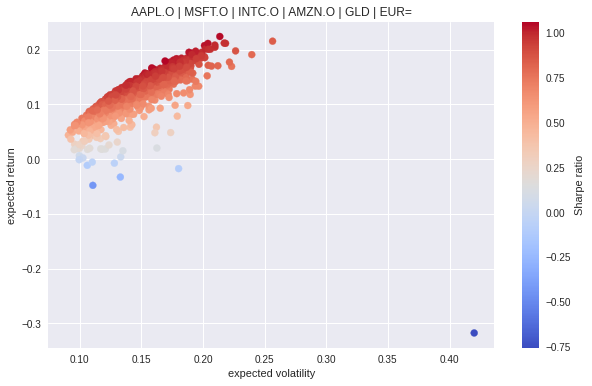

In [6]:
pvr,psr=pf.simul_portfolio(True)

# uses optimization techniques with freely defined bounds (say, "every asset shall have a minimum allocation of 5%") to 
    1.derive the minimum risk portfolio
    2.derive the maximum Sharpe portfolio
    3.derive and visualize the efficient frontier

In [7]:
opt=pf.opt()
opt

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


,AAPL.O,MSFT.O,INTC.O,AMZN.O,GLD,EUR=,Sharpe,Vol,Return
Max_Sharpe,0.387982,0.181082,-0.050000,0.297366,0.233570,-0.050000,1.081916,0.182865,0.197845
Min_Vol,0.042094,0.053582,0.026611,0.011423,0.158728,0.707562,0.128963,0.081251,0.010478


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


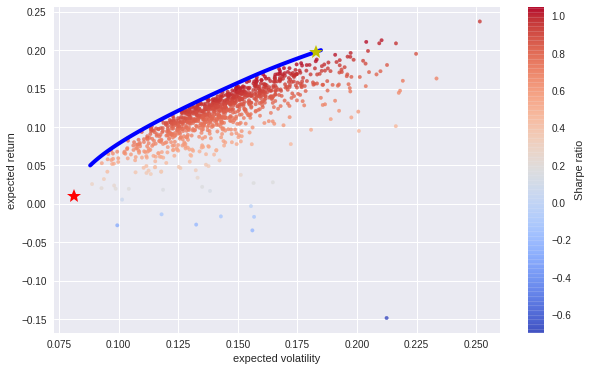

In [8]:
pf.efficient_frontier()